In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import scipy 
from scipy import stats,signal
import statsmodels.api as sm
 

# Arduino Code

In [2]:
import serial, time

def Arduino():
    ser = serial.Serial(port='/dev/cu.usbmodem1421', baudrate=22000)

    if ser.isOpen():
        print("{} connected!".format(ser.port))
        try:
            start = time.time()
            
            gryo = {'X':[], 'Y': [], 'Z': []}
            acc = {'X':[], 'Y': [], 'Z': []}
            while True:  
                
                try:
                    line_byte = ser.readline().strip().decode("UTF-8")
                except: continue
                if 'Gryo' in line_byte:
                    try:
                        line = line_byte.split('\t')
                        gryo['X'].append(line[1])
                        gryo['Y'].append(line[2])
                        gryo['Z'].append(line[3])
                        
                    except:
                        continue

                if 'Acc' in line_byte:
                    try:
                        line = line_byte.split('\t')
                        acc['X'].append(line[1])
                        acc['Y'].append(line[2])
                        acc['Z'].append(line[3])
                       
                    except:
                        continue
                    
                    if time.time() - start > 3:
                        break
            return gryo, acc

        except KeyboardInterrupt:
            print("KeyboardInterrupt has been caught.")

In [3]:
# gryo,acc = Arduino()

# Data Preprocessing

In [4]:
gryo_base,acc_base = Arduino()
print(len(gryo_base['X']))

/dev/cu.usbmodem1421 connected!
80


In [5]:
gryo = pd.DataFrame(gryo_base)
acc = pd.DataFrame(acc_base)

col = ['X','Y','Z']

for i in col:
    gryo[[str(i)]] = gryo[[i]].astype(float)
    acc[[str(i)]] = acc[[i]].astype(float)
    
    
# for i in col:
#     gryo[str(i)] = gryo[i] / 32768
#     acc[str(i)] = acc[i] /32768
    
gryo.shape, acc.shape

((80, 3), (80, 3))

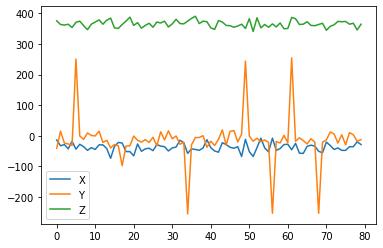

In [6]:
gryo.plot()

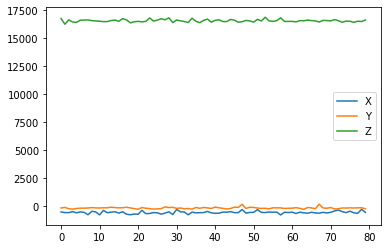

In [7]:
acc.plot()

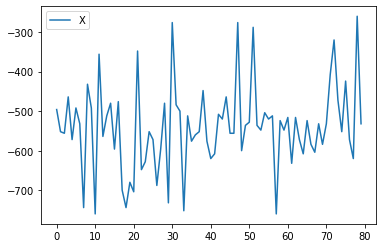

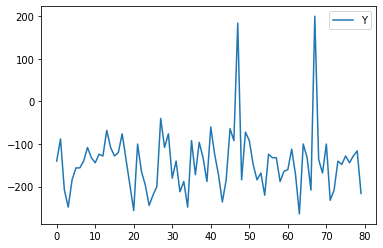

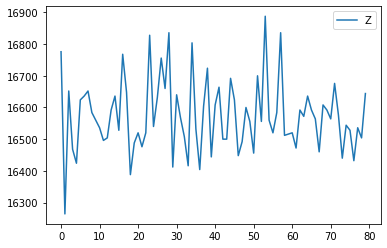

In [8]:
acc.iloc[:128,:][['X']].plot()
acc.iloc[:128,:][['Y']].plot()
acc.iloc[:128,:][['Z']].plot()

In [9]:
acc.describe()

,X,Y,Z
count,80.00000,80.000000,80.000000
mean,-540.75000,-142.600000,16573.900000
std,108.52492,74.150992,114.406294
min,-760.00000,-264.000000,16264.000000
25%,-596.00000,-185.000000,16503.000000
50%,-542.00000,-140.000000,16562.000000
75%,-495.00000,-111.000000,16636.000000
max,-260.00000,200.000000,16888.000000


In [10]:
gryo.describe()

,X,Y,Z
count,80.000000,80.000000,80.00000
mean,-38.487500,-13.037500,365.80000
std,13.951992,71.830575,11.07786
min,-74.000000,-256.000000,341.00000
25%,-48.000000,-24.750000,358.75000
50%,-39.000000,-15.000000,365.00000
75%,-29.000000,-0.750000,373.25000
max,-8.000000,255.000000,391.00000


In [11]:
def butter_lowpass(cutoff, nyq_freq, order): ##CORRECT
    normal_cutoff = float(cutoff) / nyq_freq
    b, a = signal.butter(order, normal_cutoff, btype='lowpass')
    return b, a

def butter_lowpass_filter(data, cutoff_freq, nyq_freq, order): ##CORRECT
    b, a = butter_lowpass(cutoff_freq, nyq_freq, order=order)
    y = signal.filtfilt(b, a, data) 
    return y


def median_filter(data, f_size): ##CORRECT
    lgth, num_signal = data.shape
    f_data = np.zeros([lgth, num_signal])
    for i in range(num_signal):
        f_data[:,i]=signal.medfilt(data.iloc[:,i], f_size)
    return pd.DataFrame(f_data, columns = ['X','Y','Z'])

def mag(df):
    result = []
    for i in range(df.shape[0]):

        x, y, z = df.iloc[i,:].values
        mag = np.sqrt(x**2 + y**2 + z**2)

        result.append(mag)
    return result




# Fourier Transform
def FFT(x):
#     x = np.asarray(x, dtype=float)
#     N = x.shape[0]
#     n = np.arange(N)
#     k = n.reshape((N, 1))
#     M = np.exp(-2j * np.pi * k * n / N)
#     return np.dot(M, x)
    return np.fft.fft(x).real


# Features

In [12]:

sample_rate = 50
signal_length = 2.56 * sample_rate  # 2.56 seconds
cutoff_frequency = 20.0  # 20Hz


tGyro = pd.DataFrame(columns=['X','Y','Z'])
tAcc = pd.DataFrame(columns=['X','Y','Z'])


med_gryo = median_filter(gryo,3)
med_acc = median_filter(acc,3)


for i in col:
    tGyro[i] = butter_lowpass_filter(med_gryo[i], cutoff_frequency, sample_rate/2, 3)
    tAcc[i] = butter_lowpass_filter(med_acc[i], cutoff_frequency, sample_rate/2, 3)

tBodyGyro = tGyro


tGravityAcc = pd.DataFrame(columns=['X','Y','Z'])
tBodyAcc = pd.DataFrame(columns=['X','Y','Z'])

tBodyAccJerk = pd.DataFrame(columns=['X','Y','Z'])
tBodyGyroJerk = pd.DataFrame(columns=['X','Y','Z'])


for i in col:
    tGravityAcc[i] = butter_lowpass_filter(tAcc[i], 0.3, sample_rate/2, 3)
    tBodyAcc[i] = tAcc[i] - tGravityAcc[i] 

    #Derivative
    tBodyAccJerk[i] = tBodyAcc[i].diff()
    tBodyGyroJerk[i] = tBodyGyro[i].diff()


tBodyAccJerk.fillna(0, inplace = True)
tBodyGyroJerk.fillna(0, inplace = True)


# Magnitude
tBodyAccMag = pd.DataFrame(columns=['tBodyAccMag'])
tBodyAccMag['tBodyAccMag'] =  mag(tBodyAcc)

tGravityAccMag = pd.DataFrame(columns=['tGravityAccMag'])
tGravityAccMag['tGravityAccMag'] = mag(tGravityAcc)

tBodyAccJerkMag = pd.DataFrame(columns=['tBodyAccJerkMag'])
tBodyAccJerkMag['tBodyAccJerkMag'] = mag(tBodyAccJerk)

tBodyGyroMag = pd.DataFrame(columns=['tBodyGyroMag'])
tBodyGyroMag['tBodyGyroMag'] = mag(tBodyGyro)

tBodyGyroJerkMag = pd.DataFrame(columns=['tBodyGyroJerkMag'])
tBodyGyroJerkMag['tBodyGyroJerkMag'] = mag(tBodyGyroJerk)

#CHECKED


# Fourier Transform
fBodyAcc= pd.DataFrame(columns=['X','Y','Z'])
fBodyAccJerk = pd.DataFrame(columns=['X','Y','Z'])
fBodyGyro = pd.DataFrame(columns=['X','Y','Z'])

for i in col:
    fBodyAcc[i] = FFT(tBodyAcc[i])
    fBodyAccJerk[i] = FFT(tBodyAccJerk[i])    
    fBodyGyro[i] = FFT(tBodyGyro[i])    

fBodyAccMag = pd.DataFrame(columns=['fBodyAccMag'])
fBodyAccMag['fBodyAccMag'] = np.squeeze(FFT(tBodyAccMag))  

fBodyAccJerkMag = pd.DataFrame(columns=['fBodyAccJerkMag'])
fBodyAccJerkMag['fBodyAccJerkMag'] = np.squeeze(FFT(tBodyAccJerkMag))    

fBodyGyroMag = pd.DataFrame(columns=['fBodyGyroMag'])
fBodyGyroMag['fBodyGyroMag'] = np.squeeze(FFT(tBodyGyroMag))  

fBodyGyroJerkMag = pd.DataFrame(columns=['fBodyGyroJerkMag'])
fBodyGyroJerkMag['fBodyGyroJerkMag'] = np.squeeze(FFT(tBodyGyroJerkMag))   

### FFT

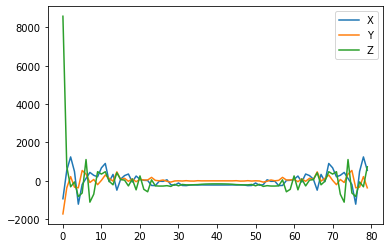

In [13]:
fBodyAcc.plot()

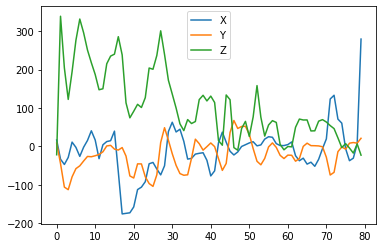

In [14]:
tBodyAcc.plot()

### Jerk

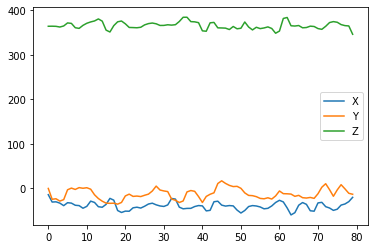

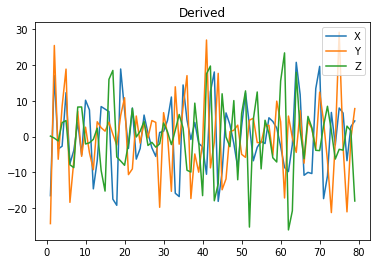

In [15]:
# tBodyAccJerk[i] = tBodyAcc[i].diff()

plt.figure(1)
plt.plot(tBodyGyro['X'], label= 'X')
plt.plot(tBodyGyro['Y'], label= 'Y')
plt.plot(tBodyGyro['Z'], label= 'Z')
plt.legend()


plt.figure(2)
plt.title('Derived')
plt.plot(tBodyGyroJerk['X'].diff(),label= 'X')
plt.plot(tBodyGyroJerk['Y'].diff(),label= 'Y')
plt.plot(tBodyGyroJerk['Z'].diff(),label= 'Z')
plt.legend()

plt.show()

### Magnitude

In [16]:
tBodyAccMag = pd.DataFrame(columns=['tBodyAccMag'])
tBodyAccMag['tBodyAccMag'] =  mag(tBodyAcc)

<Figure size 432x288 with 0 Axes>

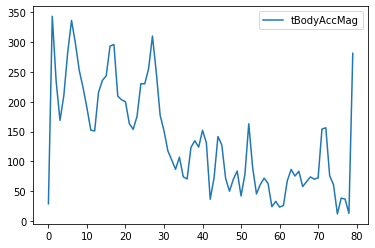

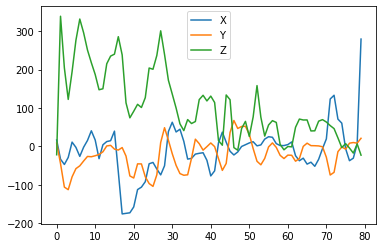

In [17]:
plt.figure(1)
tBodyAccMag.plot()


plt.figure(2)
tBodyAcc.plot()

plt.show()

In [18]:
tBodyAcc.iloc[4,:].values

array([ 11.21739677, -79.22760611, 194.58079523])

In [19]:
tBodyAcc.head()

,X,Y,Z
0,16.780184,8.386211,-21.671699
1,-33.267848,-44.641944,339.050489
2,-46.993528,-105.949293,204.503521
3,-28.653046,-112.615452,122.453163
4,11.217397,-79.227606,194.580795


In [20]:
# Mean Calculation
def mean(x):
    mean_x = np.mean(x)
    return mean_x

# Standard Deviation Calculation
def std_dev(x):
    std_x = np.std(x)
    return std_x

# Median Absolute Deviation Calculation
def mad(x):
    mad_x = np.median(np.abs(x - np.median(x)))
    return mad_x
    
# Min Calculation
def min_value(x):
    return min(x)

# Max Calculation
def max_value(x):
    return max(x)

# Signal Magnitude Area Calculation
def sma(signal):
    x,y,z = signal['X'],signal['Y'],signal['Z']
    abs_x = np.absolute(x)
    abs_y = np.absolute(y)
    abs_z = np.absolute(z)
    return np.mean(abs_x + abs_y + abs_z)

#one Column
def sma2(signal):
    abs_ = np.absolute(signal)
    return np.mean(abs_)


# Energy measure. Sum of the squares divided by the number of values. 
def energy_measure(x):
    em_x = np.mean(np.square(x))
    return em_x

# Inter-quartile range Calculation
def inter_quartile_range(x):
    iqr_x = np.subtract(*np.percentile(x, [75, 25]))
    return iqr_x


# entropy(): Signal entropy
def entropy(x):
    entr = stats.entropy(x)
    

        
    return entr

# arCoeff(): Autorregresion coefficients with Burg order equal to 4
def arCoeff(signal,order):
    _, sigma = sm.regression.linear_model.burg(signal, order=order)
    return sigma

# correlation(): correlation coefficient between two signals
def coor(signal):
    corr = tBodyAcc.corr()
    x_y = corr.loc['X','Y']
    x_z = corr.loc['X','Z']
    y_z = corr.loc['Y','Z']
    
    return x_y, x_z, y_z


# maxInds(): index of the frequency component with largest magnitude
def maxInds(x):
    idx_x = np.argmax(x)
    return idx_x


# meanFreq(): Weighted average of the frequency components to obtain a mean frequency
def meanFreq(signal):
    return np.mean(signal)


# skewness(): skewness of the frequency domain signal 
def skewness(x):
    skew_x=stats.skew(x)
    return skew_x

# kurtosis(): kurtosis of the frequency domain signal 
def kurtosis(x):
    kurt_x = stats.kurtosis(x,fisher=False)
    return kurt_x
    

# bandsEnergy(): Energy of a frequency interval within the 64 bins of the FFT of each window.
def bandpower(x, fmin, fmax, fs=1):
    f, Pxx = scipy.signal.periodogram(x,fs=fs)
    ind_min = np.argmax(f > fmin) - 1
    ind_max = np.argmax(f > fmax) - 1
    return np.trapz(Pxx[ind_min: ind_max], f[ind_min: ind_max])

# angle(): Angle between to vectors.
def angle_calc(vector_1,vector_2):
    unit_vector_1 = vector_1 / np.linalg.norm(vector_1)
    unit_vector_2 = vector_2 / np.linalg.norm(vector_2)
    dot_product = np.dot(unit_vector_1, unit_vector_2)
    angle = np.arccos(dot_product)
    return angle

def angle(signal):
    g = 9.80665
    try:
        l = [g for _ in range(signal.shape[0])] 
    except:
        l = g
    
    angle_value = angle_calc(signal, l)

    return angle_value


In [21]:
col = ['X','Y','Z']
for i in col:  
    print(entropy(tBodyAcc[i]))
    for count in range(1,5):
        print(arCoeff(tBodyAcc[i], count))
        

-inf
1775.8620611133597
1382.1967067059288
1357.7710865620402
1366.864413642286
-inf
627.423253802868
369.92854179376815
302.823894615274
254.55402676483718
-inf
3491.2959579029325
2818.20334389831
2404.8721194419027
2308.5875578596274


# Feature Collections

In [22]:
def feature_40(signal, name):
    l = [ 'mean_X', 'mean_Y', 'mean_Z',
         'std_X','std_Y', 'std_Z',
         'mad_X','mad_Y', 'mad_Z',
         'max_X','max_Y', 'max_Z',
         'min_X','min_Y', 'min_Z',
         'sma',
         'energy_X', 'energy_Y','energy_Z',
         'iqr_X','iqr_Y','iqr_Z',
         'entropy_X', 'entropy_Y', 'entropy_Z',
         'X_1','X_2','X_3','X_4','Y_1','Y_2','Y_3','Y_4', 'Z_1','Z_2','Z_3','Z_4',
         'correlation_x_y','correlation_x_z', 'correlation_y_z'
         ]
    col = ['X','Y','Z']
    fet_40 = dict()
    
    for i in col:
        fet_40['mean_' + i ] = mean(signal[i])
        fet_40['std_' + i ] = std_dev(signal[i])
        fet_40['mad_' + i ] = mad(signal[i])
        fet_40['max_' + i ] = max_value(signal[i])
        fet_40['min_' + i ] = min_value(signal[i])
        fet_40['energy_' + i ] = energy_measure(signal[i])
        fet_40['iqr_' + i ] = inter_quartile_range(signal[i])
        fet_40['entropy_' + i ] = entropy(signal[i])
        
        for count in range(1,5):
            fet_40[i + '_' + str(count)] = arCoeff(signal[i], count)
        
    fet_40['sma'] = sma(signal)
    fet_40['correlation_x_y'] = coor(signal)[0]
    fet_40['correlation_x_z'] = coor(signal)[1]
    fet_40['correlation_y_z'] = coor(signal)[2]
    
    res = {}
    for key in l:
        res[name+'_'+key] = fet_40[key]
    
    return res

def feature_13(signal, name):
    fet_13 = dict()
    
    fet_13[name + '_mean'] = mean(signal)
    fet_13[name + '_std'] = std_dev(signal)
    fet_13[name + '_mad'] = mad(signal)
    fet_13[name + '_max'] = max_value(signal)
    fet_13[name + '_min'] = min_value(signal)
    fet_13[name + '_sma'] = sma2(signal)
    fet_13[name + '_energy'] = energy_measure(signal)
    fet_13[name + '_iqr'] = inter_quartile_range(signal)
    fet_13[name + '_entropy'] = entropy(signal)
    
    for count in range(1,5):
        fet_13[name + '_AR_' + str(count)] = arCoeff(signal, count)
    
    return fet_13

def feature_80(signal, name):
    l = ['mean_X', 'mean_Y', 'mean_Z',
         'std_X','std_Y', 'std_Z',
         'mad_X','mad_Y', 'mad_Z',
         'max_X','max_Y', 'max_Z',
         'min_X','min_Y', 'min_Z',
         'sma',
         'energy_X', 'energy_Y','energy_Z',
         'iqr_X', 'iqr_Y', 'iqr_Z',
         'entropy_X', 'entropy_Y', 'entropy_Z',
         'maxInds_X', 'maxInds_Y', 'maxInds_Z',
         'meanFreq_X', 'meanFreq_Y', 'meanFreq_Z',
         'skewness_X', 'kurtosis_X', 'skewness_Y', 'kurtosis_Y', 'skewness_Z', 'kurtosis_Z',
         'bandpower_X-1-8', 'bandpower_X-9-16', 'bandpower_X-17-24', 'bandpower_X-25-32', 'bandpower_X-33-40', 
         'bandpower_X-41-48', 'bandpower_X-49-56', 'bandpower_X-57-64', 
         'bandpower_X-1-16', 'bandpower_X-17-32', 'bandpower_X-33-48', 'bandpower_X-49-64',
         'bandpower_X-1-24', 'bandpower_X-25-48',
         
         'bandpower_Y-1-8', 'bandpower_Y-9-16', 'bandpower_Y-17-24', 'bandpower_Y-25-32', 'bandpower_Y-33-40', 
         'bandpower_Y-41-48', 'bandpower_Y-49-56', 'bandpower_Y-57-64', 
         'bandpower_Y-1-16', 'bandpower_Y-17-32', 'bandpower_Y-33-48', 'bandpower_Y-49-64', 
         'bandpower_Y-1-24', 'bandpower_Y-25-48',
         
         'bandpower_Z-1-8', 'bandpower_Z-9-16', 'bandpower_Z-17-24', 'bandpower_Z-25-32', 'bandpower_Z-33-40', 
         'bandpower_Z-41-48', 'bandpower_Z-49-56', 'bandpower_Z-57-64', 
         'bandpower_Z-1-16', 'bandpower_Z-17-32', 'bandpower_Z-33-48', 'bandpower_Z-49-64', 
         'bandpower_Z-1-24', 'bandpower_Z-25-48' 
         ]

    col = ['X','Y','Z']
    fet_80 = dict()
    
    for i in col:
        fet_80['mean_' + i ] = mean(signal[i])
        fet_80['std_' + i ] = std_dev(signal[i])
        fet_80['mad_' + i ] = mad(signal[i])
        fet_80['max_' + i ] = max_value(signal[i])
        fet_80['min_' + i ] = min_value(signal[i])
        fet_80['energy_' + i ] = energy_measure(signal[i])
        fet_80['iqr_' + i ] = inter_quartile_range(signal[i])
        fet_80['entropy_' + i ] = entropy(signal[i])
        
        fet_80['maxInds_' + i ] = maxInds(signal[i])
        fet_80['meanFreq_' + i ] = meanFreq(signal[i])
        
        fet_80['skewness_' + i] = skewness(signal[i])
        fet_80['kurtosis_' + i] = kurtosis(signal[i])
        

        for j in range(1,65,8):
            fet_80['bandpower_' + i + '-' + str(j) + '-' + str(j+7) ] = bandpower(signal[i], j, j+7)
            
        for k in range(1,65,16):
            fet_80['bandpower_' + i + '-' + str(k) + '-' + str(k+15) ] = bandpower(signal[i], k, k+15)

        for q in range(1,65,24):
            if q+23 > 65:break
            fet_80['bandpower_' + i + '-' + str(q) + '-' + str(q+23)] = bandpower(signal[i], q, q+23) 
        
        
    fet_80['sma'] = sma(signal)

    
    res = {}
    for key in l:
        res[name+'_'+key] = fet_80[key]
    
    return res

def feature_13_MAG(signal, name):
    fet_mag = dict()
    
    fet_mag[name + '_mean'] = mean(signal)
    fet_mag[name + '_std'] = std_dev(signal)
    fet_mag[name + '_mad'] = mad(signal)
    fet_mag[name + '_max'] = max_value(signal)
    fet_mag[name + '_min'] = min_value(signal)
    fet_mag[name + '_sma'] = sma2(signal)
    fet_mag[name + '_energy'] = energy_measure(signal)
    fet_mag[name + '_iqr'] = inter_quartile_range(signal)
    fet_mag[name + '_entropy'] = entropy(signal)
    
    fet_mag[name + '_maxInds' ] = maxInds(signal)
    fet_mag[name + '_meanFreq'] = meanFreq(signal)
    fet_mag[name + '_skewness'] = skewness(signal)
    fet_mag[name + '_kurtosis'] = kurtosis(signal)    
    
    return fet_mag

def last_features():
    feat = dict()
    
    feat['tBodyAccMean_angle'] = angle(tBodyAcc.mean())
    feat['tBodyAccJerkMean_angle'] = angle(tBodyAccJerk.mean())
    feat['tBodyGyroMean_angle'] = angle(tBodyGyro.mean())
    feat['tBodyGyroJerkMean_angle'] = angle(tBodyGyroJerk.mean())
    
    feat['tGravityAcc_X_angle'] = angle(tGravityAcc['X'])
    feat['tGravityAcc_Y_angle'] = angle(tGravityAcc['Y'])
    feat['tGravityAcc_Z_angle'] = angle(tGravityAcc['Z'])

    return feat  

In [23]:
def collectFeatures():
    res = dict()
    
    feat40 = {'tBodyAcc':tBodyAcc,'tGravityAcc': tGravityAcc,'tBodyAccJerk':tBodyAccJerk,
              'tBodyGyro':tBodyGyro,'tBodyGyroJerk': tBodyGyroJerk} 
    for k,v in feat40.items():
        res.update(feature_40(v,k ))
    
    
    
    feat13 = {'tBodyAccMag': tBodyAccMag,'tGravityAccMag': tGravityAccMag,
              'tBodyAccJerkMag': tBodyAccJerkMag,'tBodyGyroMag': tBodyGyroMag,
              'tBodyGyroJerkMag':tBodyGyroJerkMag}
    for k,v in feat13.items():
        res.update(feature_13(v[k],k ))
    
    
    
    feat_80 = {'fBodyAcc': fBodyAcc, 'fBodyAccJerk': fBodyAccJerk, 'fBodyGyro': fBodyGyro}
    for k,v in feat_80.items():
        res.update(feature_80(v,k ))
    
    
    
    feat13_mag = {'fBodyAccMag':fBodyAccMag,'fBodyAccJerkMag': fBodyAccJerkMag,
                  'fBodyGyroMag': fBodyGyroMag, 'fBodyGyroJerkMag': fBodyGyroJerkMag}
    for k,v in feat13_mag.items():
        res.update(feature_13_MAG(v[k],k ))
    
    res.update(last_features())
    return res

In [24]:
if __name__ == '__main__':
    result = collectFeatures()
    result = pd.DataFrame(result, index=[0])
    result.to_csv('test_data.csv', index = False)

/Users/serik/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:2664: RuntimeWarning: divide by zero encountered in true_divide
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


In [25]:
result

,tBodyAcc_mean_X,tBodyAcc_mean_Y,tBodyAcc_mean_Z,tBodyAcc_std_X,tBodyAcc_std_Y,tBodyAcc_std_Z,tBodyAcc_mad_X,tBodyAcc_mad_Y,tBodyAcc_mad_Z,tBodyAcc_max_X,...,fBodyGyroJerkMag_meanFreq,fBodyGyroJerkMag_skewness,fBodyGyroJerkMag_kurtosis,tBodyAccMean_angle,tBodyAccJerkMean_angle,tBodyGyroMean_angle,tBodyGyroJerkMean_angle,tGravityAcc_X_angle,tGravityAcc_Y_angle,tGravityAcc_Z_angle
0,-11.708237,-21.590938,107.268395,64.083172,38.849103,92.57969,27.353564,25.041055,58.267455,279.578624,...,11.85076,0,0,1.172248,0.924276,1.054993,2.760335,3.12658,3.04247,0.004451


In [26]:
pd.options.display.max_columns = 9999
pd.options.display.float_format = '{:,.5f}'.format
result

,tBodyAcc_mean_X,tBodyAcc_mean_Y,tBodyAcc_mean_Z,tBodyAcc_std_X,tBodyAcc_std_Y,tBodyAcc_std_Z,tBodyAcc_mad_X,tBodyAcc_mad_Y,tBodyAcc_mad_Z,tBodyAcc_max_X,tBodyAcc_max_Y,tBodyAcc_max_Z,tBodyAcc_min_X,tBodyAcc_min_Y,tBodyAcc_min_Z,tBodyAcc_sma,tBodyAcc_energy_X,tBodyAcc_energy_Y,tBodyAcc_energy_Z,tBodyAcc_iqr_X,tBodyAcc_iqr_Y,tBodyAcc_iqr_Z,tBodyAcc_entropy_X,tBodyAcc_entropy_Y,tBodyAcc_entropy_Z,tBodyAcc_X_1,tBodyAcc_X_2,tBodyAcc_X_3,tBodyAcc_X_4,tBodyAcc_Y_1,tBodyAcc_Y_2,tBodyAcc_Y_3,tBodyAcc_Y_4,tBodyAcc_Z_1,tBodyAcc_Z_2,tBodyAcc_Z_3,tBodyAcc_Z_4,tBodyAcc_correlation_x_y,tBodyAcc_correlation_x_z,tBodyAcc_correlation_y_z,tGravityAcc_mean_X,tGravityAcc_mean_Y,tGravityAcc_mean_Z,tGravityAcc_std_X,tGravityAcc_std_Y,tGravityAcc_std_Z,tGravityAcc_mad_X,tGravityAcc_mad_Y,tGravityAcc_mad_Z,tGravityAcc_max_X,tGravityAcc_max_Y,tGravityAcc_max_Z,tGravityAcc_min_X,tGravityAcc_min_Y,tGravityAcc_min_Z,tGravityAcc_sma,tGravityAcc_energy_X,tGravityAcc_energy_Y,tGravityAcc_energy_Z,tGravityAcc_iqr_X,tGravityAcc_iqr_Y,tGravityAcc_iqr_Z,tGravityAcc_entropy_X,tGravityAcc_entropy_Y,tGravityAcc_entropy_Z,tGravityAcc_X_1,tGravityAcc_X_2,tGravityAcc_X_3,tGravityAcc_X_4,tGravityAcc_Y_1,tGravityAcc_Y_2,tGravityAcc_Y_3,tGravityAcc_Y_4,tGravityAcc_Z_1,tGravityAcc_Z_2,tGravityAcc_Z_3,tGravityAcc_Z_4,tGravityAcc_correlation_x_y,tGravityAcc_correlation_x_z,tGravityAcc_correlation_y_z,tBodyAccJerk_mean_X,tBodyAccJerk_mean_Y,tBodyAccJerk_mean_Z,tBodyAccJerk_std_X,tBodyAccJerk_std_Y,tBodyAccJerk_std_Z,tBodyAccJerk_mad_X,tBodyAccJerk_mad_Y,tBodyAccJerk_mad_Z,tBodyAccJerk_max_X,tBodyAccJerk_max_Y,tBodyAccJerk_max_Z,tBodyAccJerk_min_X,tBodyAccJerk_min_Y,tBodyAccJerk_min_Z,tBodyAccJerk_sma,tBodyAccJerk_energy_X,tBodyAccJerk_energy_Y,tBodyAccJerk_energy_Z,tBodyAccJerk_iqr_X,tBodyAccJerk_iqr_Y,tBodyAccJerk_iqr_Z,tBodyAccJerk_entropy_X,tBodyAccJerk_entropy_Y,tBodyAccJerk_entropy_Z,tBodyAccJerk_X_1,tBodyAccJerk_X_2,tBodyAccJerk_X_3,tBodyAccJerk_X_4,tBodyAccJerk_Y_1,tBodyAccJerk_Y_2,tBodyAccJerk_Y_3,tBodyAccJerk_Y_4,tBodyAccJerk_Z_1,tBodyAccJerk_Z_2,tBodyAccJerk_Z_3,tBodyAccJerk_Z_4,tBodyAccJerk_correlation_x_y,tBodyAccJerk_correlation_x_z,tBodyAccJerk_correlation_y_z,tBodyGyro_mean_X,tBodyGyro_mean_Y,tBodyGyro_mean_Z,tBodyGyro_std_X,tBodyGyro_std_Y,tBodyGyro_std_Z,tBodyGyro_mad_X,tBodyGyro_mad_Y,tBodyGyro_mad_Z,tBodyGyro_max_X,tBodyGyro_max_Y,tBodyGyro_max_Z,tBodyGyro_min_X,tBodyGyro_min_Y,tBodyGyro_min_Z,tBodyGyro_sma,tBodyGyro_energy_X,tBodyGyro_energy_Y,tBodyGyro_energy_Z,tBodyGyro_iqr_X,tBodyGyro_iqr_Y,tBodyGyro_iqr_Z,tBodyGyro_entropy_X,tBodyGyro_entropy_Y,tBodyGyro_entropy_Z,tBodyGyro_X_1,tBodyGyro_X_2,tBodyGyro_X_3,tBodyGyro_X_4,tBodyGyro_Y_1,tBodyGyro_Y_2,tBodyGyro_Y_3,tBodyGyro_Y_4,tBodyGyro_Z_1,tBodyGyro_Z_2,tBodyGyro_Z_3,tBodyGyro_Z_4,tBodyGyro_correlation_x_y,tBodyGyro_correlation_x_z,tBodyGyro_correlation_y_z,tBodyGyroJerk_mean_X,tBodyGyroJerk_mean_Y,tBodyGyroJerk_mean_Z,tBodyGyroJerk_std_X,tBodyGyroJerk_std_Y,tBodyGyroJerk_std_Z,tBodyGyroJerk_mad_X,tBodyGyroJerk_mad_Y,tBodyGyroJerk_mad_Z,tBodyGyroJerk_max_X,tBodyGyroJerk_max_Y,tBodyGyroJerk_max_Z,tBodyGyroJerk_min_X,tBodyGyroJerk_min_Y,tBodyGyroJerk_min_Z,tBodyGyroJerk_sma,tBodyGyroJerk_energy_X,tBodyGyroJerk_energy_Y,tBodyGyroJerk_energy_Z,tBodyGyroJerk_iqr_X,tBodyGyroJerk_iqr_Y,tBodyGyroJerk_iqr_Z,tBodyGyroJerk_entropy_X,tBodyGyroJerk_entropy_Y,tBodyGyroJerk_entropy_Z,tBodyGyroJerk_X_1,tBodyGyroJerk_X_2,tBodyGyroJerk_X_3,tBodyGyroJerk_X_4,tBodyGyroJerk_Y_1,tBodyGyroJerk_Y_2,tBodyGyroJerk_Y_3,tBodyGyroJerk_Y_4,tBodyGyroJerk_Z_1,tBodyGyroJerk_Z_2,tBodyGyroJerk_Z_3,tBodyGyroJerk_Z_4,tBodyGyroJerk_correlation_x_y,tBodyGyroJerk_correlation_x_z,tBodyGyroJerk_correlation_y_z,tBodyAccMag_mean,tBodyAccMag_std,tBodyAccMag_mad,tBodyAccMag_max,tBodyAccMag_min,tBodyAccMag_sma,tBodyAccMag_energy,tBodyAccMag_iqr,tBodyAccMag_entropy,tBodyAccMag_AR_1,tBodyAccMag_AR_2,tBodyAccMag_AR_3,tBodyAccMag_AR_4,tGravityAccMag_mean,tGravityAccMag_std,tGravityAccMag_mad,tGravityAccMag_max,tGravityAccMag_min,tGravityAccMag_sma,tGra

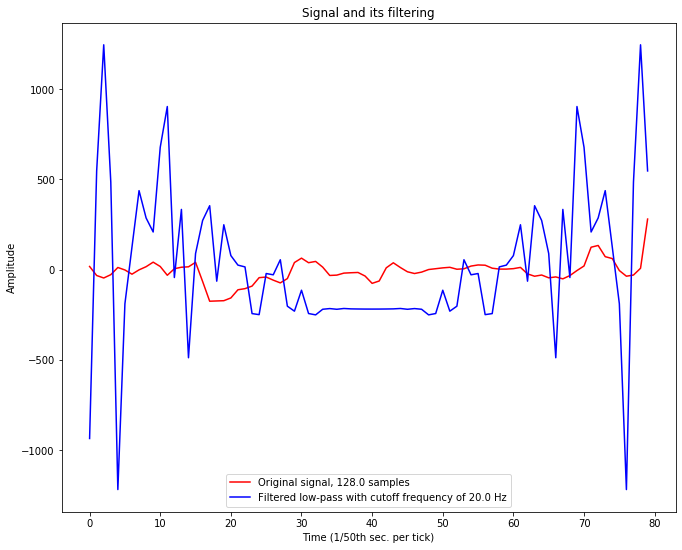

In [27]:
# Visualize
plt.figure(figsize=(11, 9))
plt.plot(tBodyAcc.X, color='red', label="Original signal, {} samples".format(signal_length))
plt.plot(fBodyAcc.X, color='blue', label="Filtered low-pass with cutoff frequency of {} Hz".format(cutoff_frequency))
# plt.plot(diff, color='gray', label="What has been removed")

plt.title("Signal and its filtering")
plt.xlabel('Time (1/50th sec. per tick)')
plt.ylabel('Amplitude')
plt.legend()
plt.show()